In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [ ]:
!unzip /content/drive/MyDrive/data/image_r_lr.zip

# Import Data

In [ ]:
import os
path_anchor = os.listdir('/content/image_r_lr/8x')
path_target = os.listdir('/content/image_r_lr/2x')
image_anchor = np.empty((len(path_anchor), 128, 128, 3), dtype='uint8')
image_target = np.empty((len(path_target), 1024, 1024, 3), dtype='uint8')
for i in range(len(path_anchor)):
  image_path  = '/content/image_r_lr/8x/' + path_anchor[i]
  image = cv2.imread(image_path)
  image = cv2.resize(image, (128, 128))
  image_anchor[i] = image
for i in range(len(path_target)):
  image_path  = '/content/image_r_lr/4x/' + path_target[i]
  image = cv2.imread(image_path)
  image = cv2.resize(image, (1024, 1024))
  image_target[i] = image

In [ ]:
image_anchor = image_anchor/255.0
image_target = image_target/255.0

In [ ]:
image_target.max()

1.0

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(image_anchor[0])

In [ ]:
plt.figure(figsize=(15, 15))
plt.imshow(image_target[0].astype('uint8'))

In [ ]:
from keras import backend as K
from numpy.linalg import norm
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.losses import MeanSquaredError
vggmodel = VGG16(include_top=False, weights='imagenet')
def VGGloss(y_true, y_pred):  # Note the parameter order
     f_p = vggmodel(y_pred)
     f_t = vggmodel(y_true)
     vgg_loss = np.dot(np.asanyarray(f_p), np.asanyarray(f_t)) / (norm(np.asanyarray(f_p))*norm(np.asanyarray(f_t)))
     return vgg_loss

In [ ]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, Input
from tensorflow.keras.models import Model

def diffusion_model(input_shape):
    # Input layer
    input_img = Input(shape=input_shape)

    # Encoding layers
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv3)

    # Decoding layers
    up1 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up1 = UpSampling2D((2, 2))(up1)
    up1 = Conv2D(128, (3, 3), activation='relu', padding='same')(up1)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(up2)
    up2 = Conv2D(64, (3, 3), activation='relu', padding='same')(up2)
    up3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2, 2))(up3)
    up3 = Conv2D(64, (3, 3), activation='relu', padding='same')(up3)
    up3 = Conv2D(32, (3, 3), activation='relu', padding='same')(up3)

    # Output layer
    output_img = Conv2D(3, (3, 3), activation='relu', padding='same')(up3)

    # Create model
    model = Model(input_img, output_img)

    return model

# Example usage
input_shape = (128, 128, 3)  # Input shape of low-resolution images
output_shape = (1024, 1024, 3)  # Output shape of super-resolution images
model = diffusion_model(input_shape)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 256)     295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 256)     590080

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
import keras
call = keras.callbacks.EarlyStopping(monitor='loss', patience=4, restore_best_weights=True)
# Compile the model
# Compile the model with the desired optimizer and loss functions
model.compile(optimizer=Adam(learning_rate=0.0001), loss=MeanSquaredError())

In [ ]:
# Train the model
from keras import backend as K
K.clear_session()
his = model.fit(image_anchor, image_target, batch_size=4, epochs=50, callbacks=[call])

Epoch 1/50
38/38 [==============================] - 88s 1s/step - loss: 0.2609
Epoch 2/50
38/38 [==============================] - 33s 869ms/step - loss: 0.1956
Epoch 3/50
38/38 [==============================] - 33s 859ms/step - loss: 0.1931
Epoch 4/50
38/38 [==============================] - 33s 867ms/step - loss: 0.1923
Epoch 5/50
38/38 [==============================] - 33s 863ms/step - loss: 0.1919
Epoch 6/50
38/38 [==============================] - 33s 863ms/step - loss: 0.1924
Epoch 7/50
38/38 [==============================] - 33s 863ms/step - loss: 0.1917
Epoch 8/50
38/38 [==============================] - 33s 864ms/step - loss: 0.1904
Epoch 9/50
38/38 [==============================] - 33s 868ms/step - loss: 0.1900
Epoch 10/50
38/38 [==============================] - 33s 866ms/step - loss: 0.1898
Epoch 11/50
38/38 [==============================] - 33s 863ms/step - loss: 0.1898
Epoch 12/50
38/38 [==============================] - 33s 865ms/step - loss: 0.1898
Epoch 13/50
38/3

In [ ]:
image_pred = model.predict(image_anchor[0:10])

In [ ]:
image_pred[0].max()

0.75298023

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(image_anchor[0])
plt.title('Anchor Image')
plt.subplot(1,3,2)
plt.imshow(image_pred[0])
plt.title('Predicted Image')
plt.subplot(1,3,3)
plt.imshow(image_target[0])
plt.title('Target Image')

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(image_anchor[1])
plt.title('Anchor Image')
plt.subplot(1,3,2)
plt.imshow(image_pred[1])
plt.title('Predicted Image')
plt.subplot(1,3,3)
plt.imshow(image_target[1])
plt.title('Target Image')

Text(0.5, 1.0, 'Target Image')

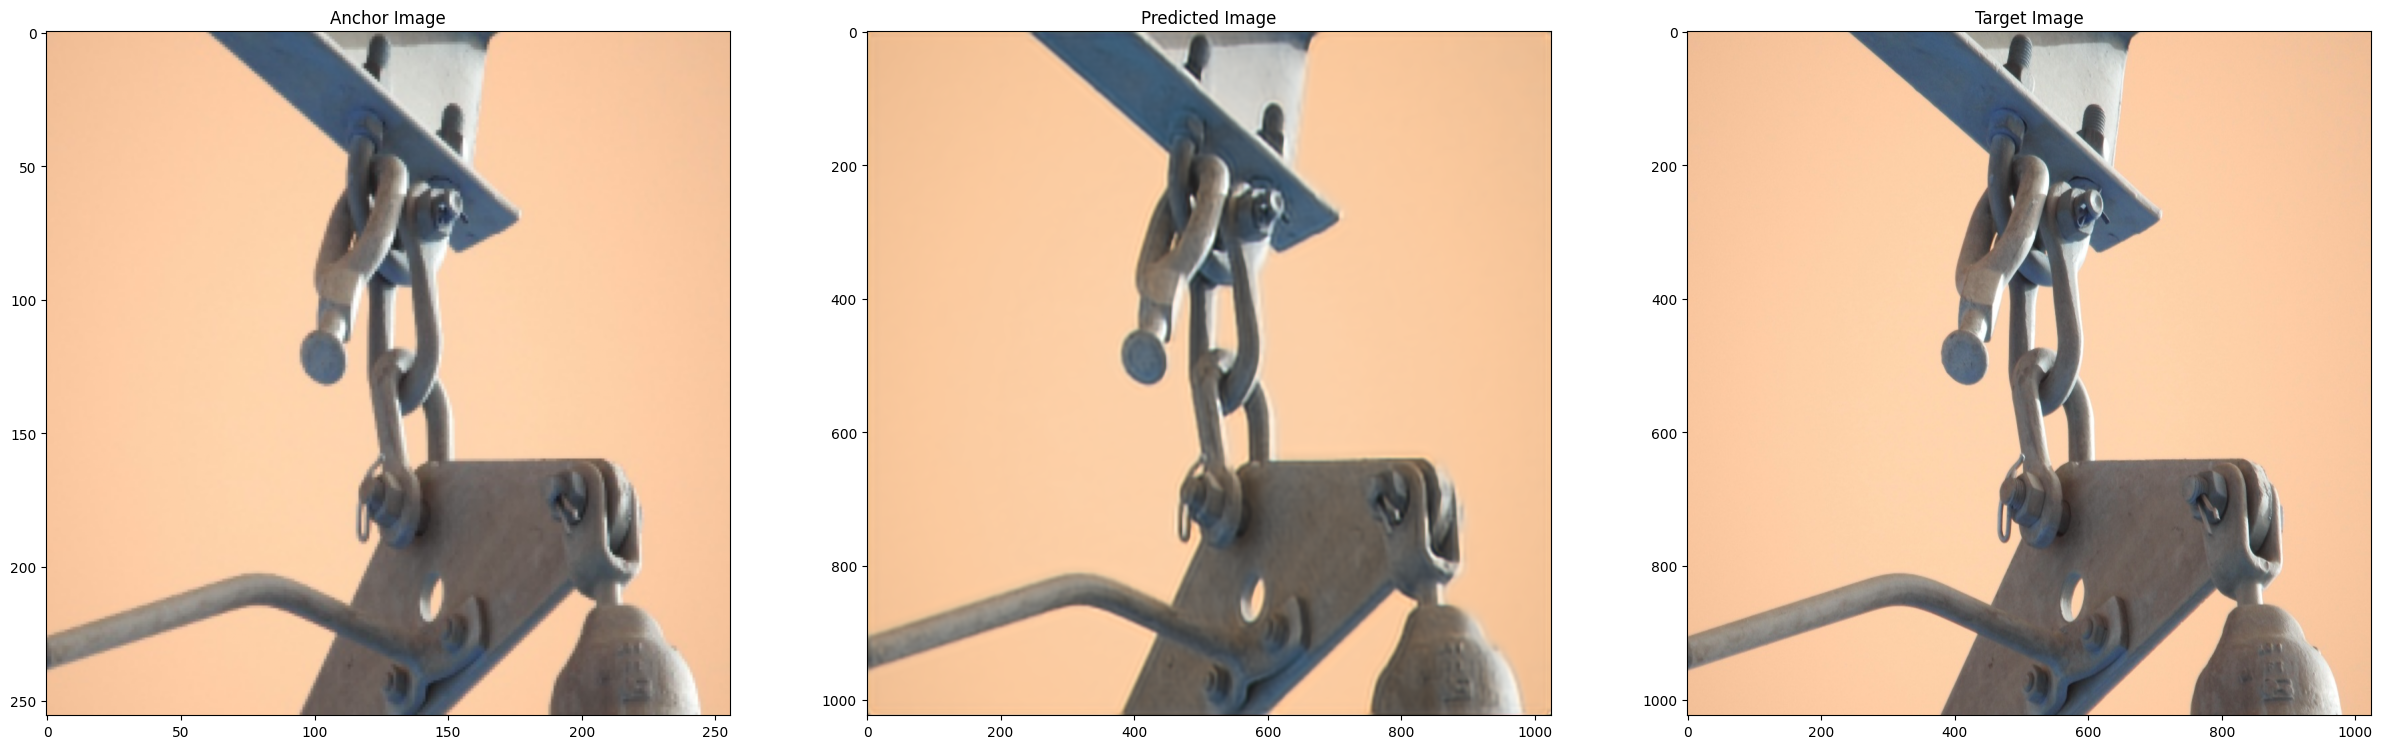

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(image_anchor[3])
plt.title('Anchor Image')
plt.subplot(1,3,2)
plt.imshow(image_pred[3])
plt.title('Predicted Image')
plt.subplot(1,3,3)
plt.imshow(image_target[3])
plt.title('Target Image')

Text(0.5, 1.0, 'Target Image')

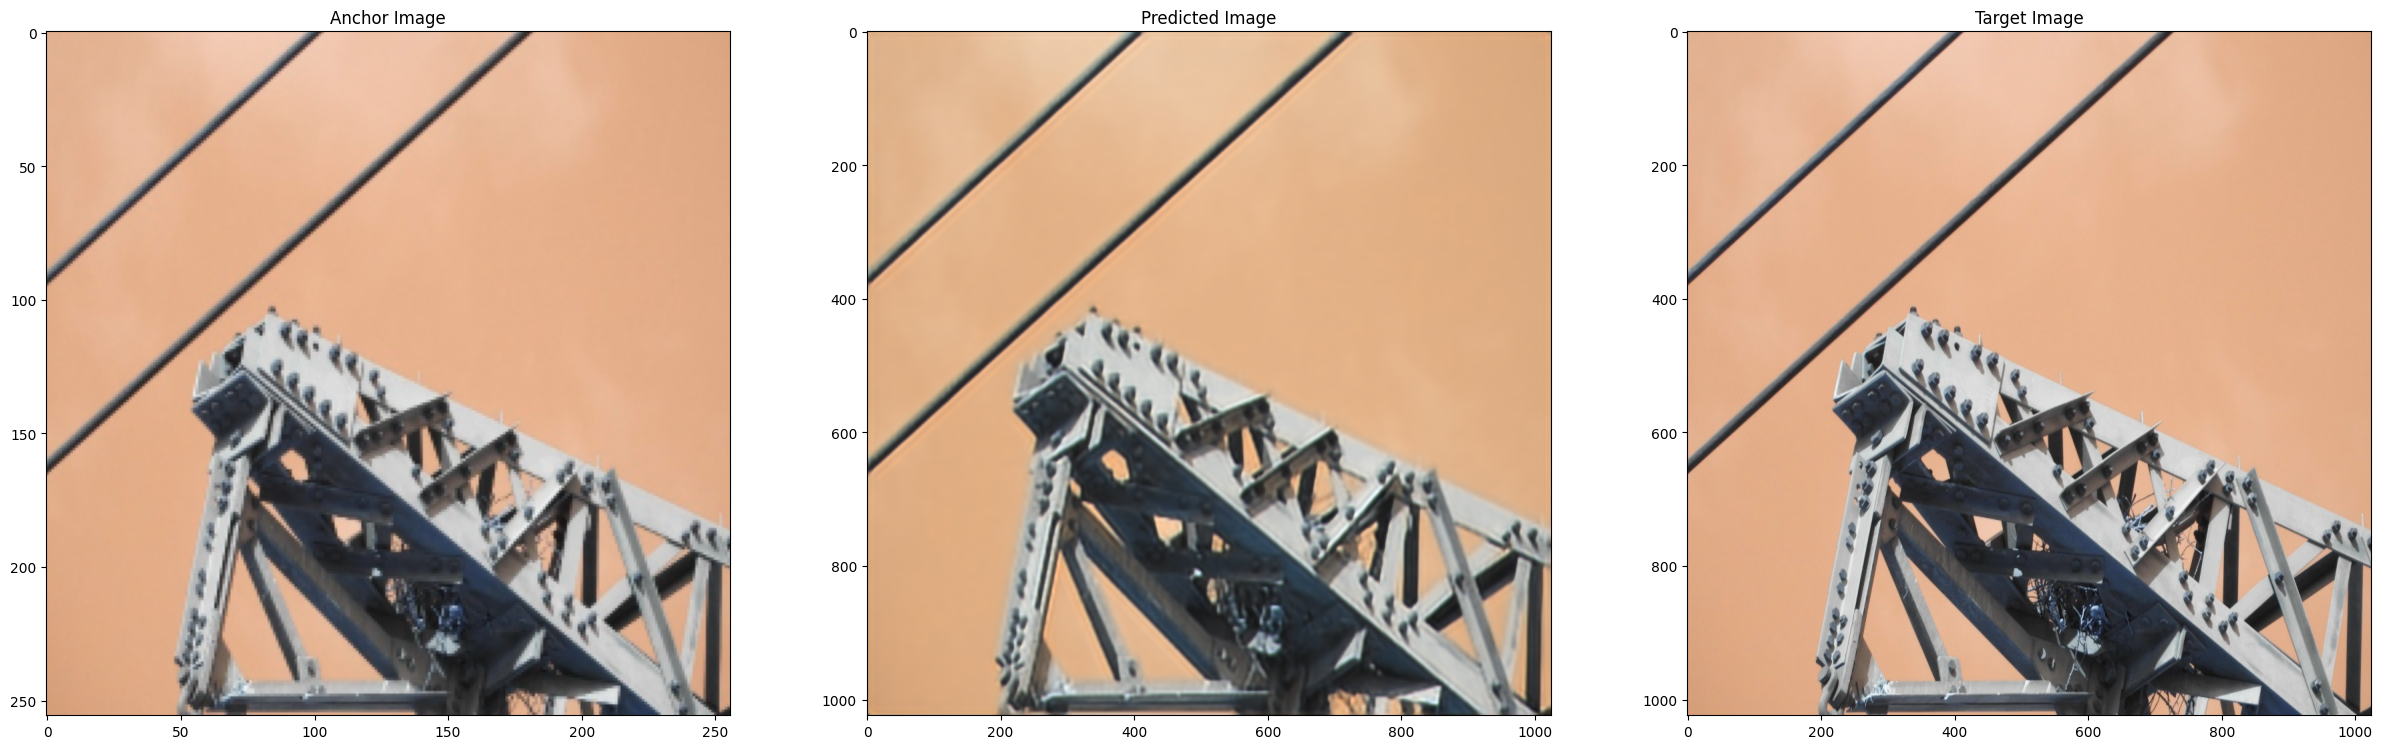

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(image_anchor[5])
plt.title('Anchor Image')
plt.subplot(1,3,2)
plt.imshow(image_pred[5])
plt.title('Predicted Image')
plt.subplot(1,3,3)
plt.imshow(image_target[5])
plt.title('Target Image')

Text(0.5, 1.0, 'Target Image')

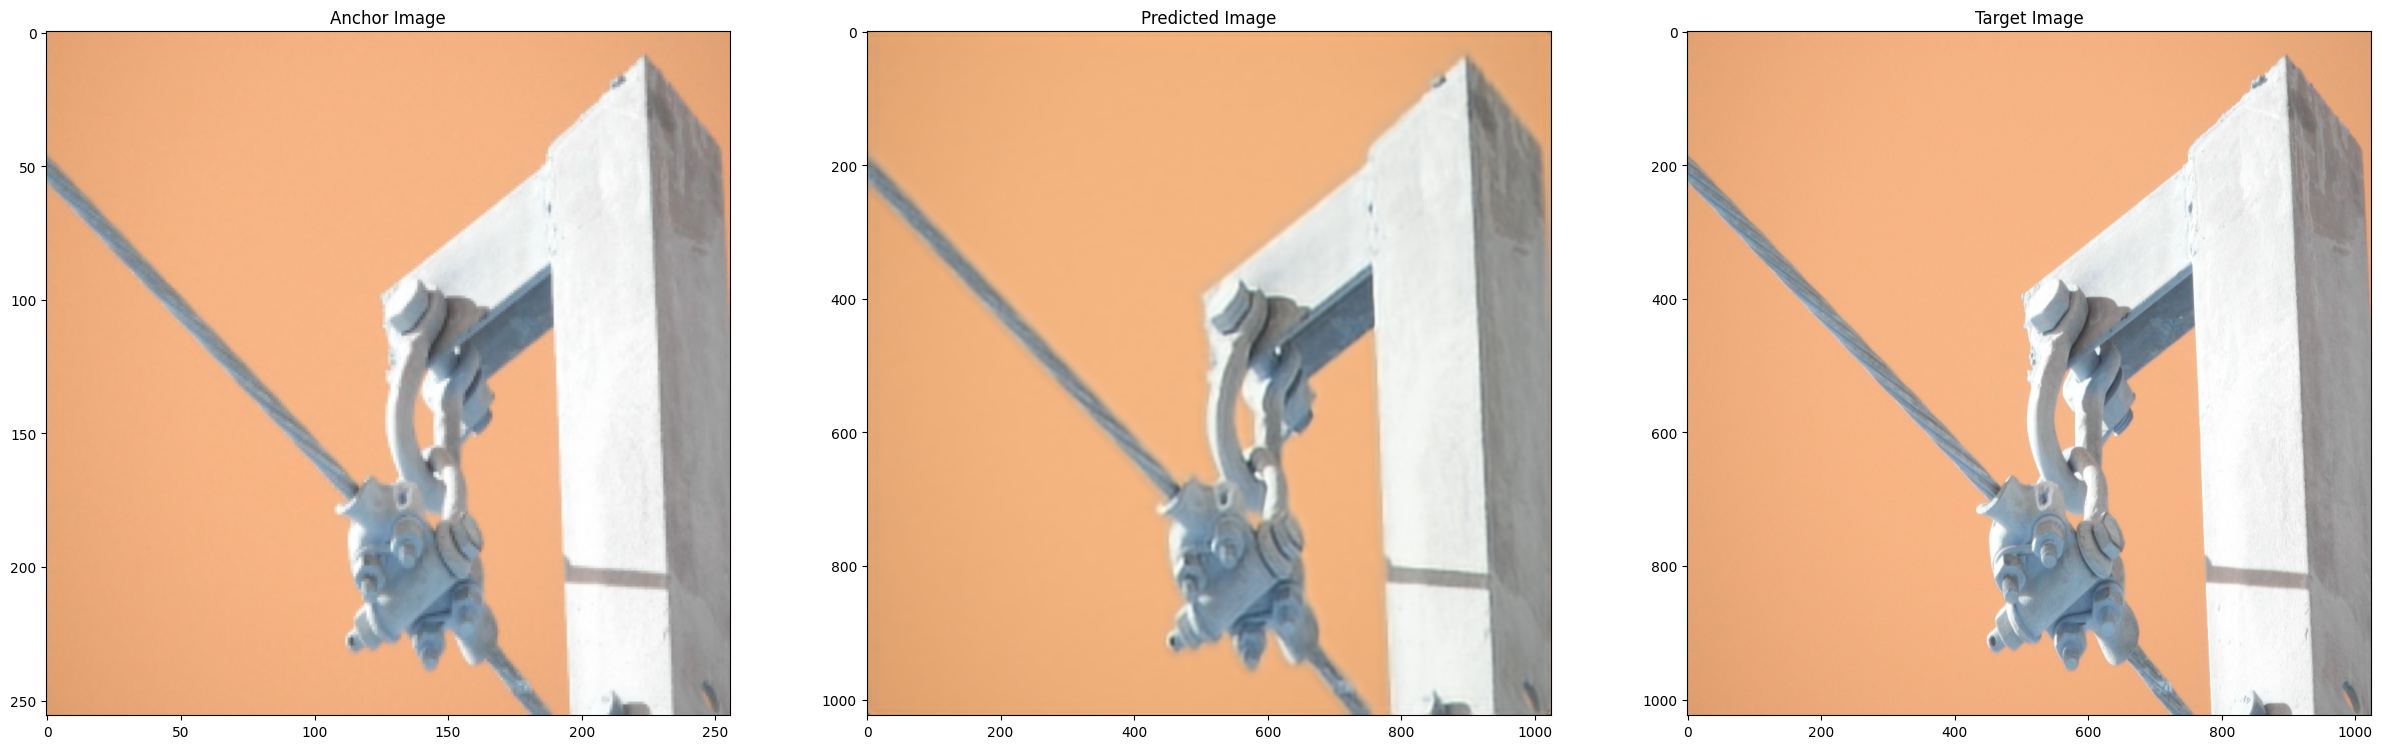

In [ ]:
plt.figure(figsize=(30, 10))
plt.subplot(1,3,1)
plt.imshow(image_anchor[9])
plt.title('Anchor Image')
plt.subplot(1,3,2)
plt.imshow(image_pred[9])
plt.title('Predicted Image')
plt.subplot(1,3,3)
plt.imshow(image_target[9])
plt.title('Target Image')

# YOLO Implantation

In [ ]:
# Load bonding boxes

In [ ]:
from PIL import Image, ImageDraw, ImageEnhance

In [ ]:
def draw_bboxes(image_id, bboxes, source='train'):
    image = Image.open('../input/global-wheat-detection/' + source +'/' + image_id + ".jpg")
    image = image.resize((256,256))

    draw = ImageDraw.Draw(image)

    for bbox in bboxes:
        draw_bbox(draw, bbox)

    return np.asarray(image)


def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=2, outline='red')